In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.distributions.uniform import Uniform # to initialise the weights in the NN
from torch.utils.data import DataLoader, TensorDataset 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightning as L

In [4]:
"""
Lets assume we have 2 simple sentences - 
Troll2 is great. 
Gymkata is great.

so, our vocab is 4 words/tokens long.
When we input Troll2 in the NN, our input would look like 1 0 0 0.
1 for Troll2, and 0 for is, great and Gymkata.
so, we are basically doing One-Hot-Encoding over our input.
"""

inputs = torch.tensor([[1.0, 0., 0., 0.],
[0., 1.0, 0., 0.],
[0., 0., 1.0, 0.],
[0., 0., 0., 1.0]])

#the goal is to create a simple NN which can predict the next token.
# we are assuming that great predicts Gymkata in our example.

labels = torch.tensor([[0., 1.0, 0., 0.], 
[0., 0., 1.0, 0.],
[0., 0., 0., 1.0],
[0., 1.0, 0., 0.]])

# we combine the input and labels into a tensor dataset
dataset = TensorDataset(inputs, labels)

In [5]:
dataloader = DataLoader(dataset) 
"""
dataloaders are useful when we have a lot of training data
making it easy to access data in batches
easier to shuffle the data in each epoch
makes it easy to use a small fraction of data
"""

'\ndataloaders are useful when we have a lot of training data\nmaking it easy to access data in batches\neasier to shuffle the data in each epoch\nmakes it easy to use a small fraction of data\n'

In [6]:
class WordEmbeddingFromScratch(L.LightningModule):
    def __init__(self):
        super().__init__()
        # using uniform distribution to generate random weights between 0.5 and -0.5, ie each value has equal probability
        min_value = -0.5
        max_value = 0.5

        self.input1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output5_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.loss= nn.CrossEntropyLoss()
        
    def forward(self, input):
        input = inputs[0] # since we have a list of lists
        inputs_to_top_hidden = (input[0] * self.input1_w1) + (input[1] * self.input2_w1) + (input[2] * self.input3_w1) + (input[3] * self.input4_w1)
        inputs_to_bottom_hidden = (input[0] * self.input1_w2) + (input[1] * self.input2_w2) + (input[2] * self.input3_w2) + (input[3] * self.input4_w2)
        # since the activation functions are the identity functions ie input is the same as the output 

        output1 = inputs_to_top_hidden * self.output1_w1 + inputs_to_bottom_hidden * self.output1_w2
        output2 = inputs_to_top_hidden * self.output2_w1 + inputs_to_bottom_hidden * self.output2_w2
        output3 = inputs_to_top_hidden * self.output3_w1 + inputs_to_bottom_hidden * self.output3_w2
        output4 = inputs_to_top_hidden * self.output4_w1 + inputs_to_bottom_hidden * self.output4_w2

        # the cross entropy loss function that we are using for backpropagation does the softmax for us
        # packaging up the output values using torch.stack
        # if instead of using torch.stack, we just returned a list of output variables by wrapping them in square brackets, then the gradients would get stripped off
        # and we wont be able to do backpropagation
        output_presoftmax = torch.stack ([output1, output2, output3, output4]) 
        return output_presoftmax
        
    def configure_optimizers(self):
        return Adam(self.parameters(), lr = 0.1)

    def training_step(self, batch, batch_idx):
        # split the batch of training data into input and labels
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i[0]) # cross entropy itself runs the output values through the softmax activation function
                                               # and quantifies the difference between the predicted softmax values and the actual target values
        return loss



In [7]:
model_from_scratch = WordEmbeddingFromScratch()

In [11]:
print(f"Before optimization the parameters are: {[ (name, param.data) for name, param in model_from_scratch.named_parameters() ]}")

Before optimization the parameters are: [('input1_w1', tensor(0.2562)), ('input1_w2', tensor(-0.1172)), ('input2_w1', tensor(0.2234)), ('input2_w2', tensor(0.2820)), ('input3_w1', tensor(-0.0059)), ('input3_w2', tensor(0.2198)), ('input4_w1', tensor(0.0887)), ('input4_w2', tensor(-0.2444)), ('output1_w1', tensor(0.3374)), ('output1_w2', tensor(0.3062)), ('output2_w1', tensor(0.0608)), ('output2_w2', tensor(0.0816)), ('output3_w1', tensor(-0.2578)), ('output4_w2', tensor(-0.1704)), ('output4_w1', tensor(0.2721)), ('output5_w2', tensor(0.0597))]


In [13]:
# creating a pandas dataframe with embeddings for each input token
param_dict = {}
for name, param in model_from_scratch.named_parameters():
    if name.startswith("input") and "_" in name:
        word, weight = name.split('_')
        if word not in param_dict:
            param_dict[word]={}
        param_dict[word][weight] = param.item()

# convert to dataframe 
df = pd.DataFrame.from_dict(param_dict, orient = 'index')
df.index.name = word

In [15]:
df['token'] = ['Troll2', 'is', 'great','Gymkata']

In [16]:
df

,w1,w2,token
input4,,,
input1,0.256189,-0.117246,Troll2
input2,0.223417,0.281986,is
input3,-0.005851,0.219785,great
input4,0.088691,-0.244402,Gymkata


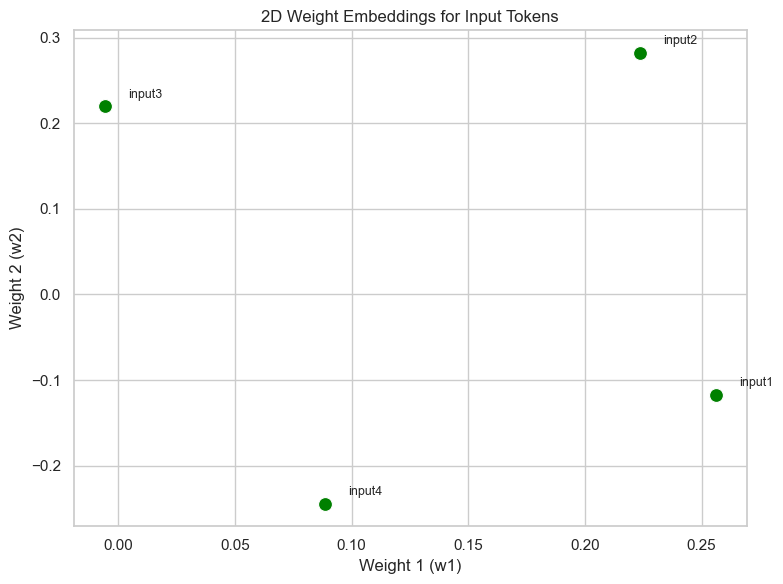

In [20]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')

sns.scatterplot(x=df['w1'], y=df['w2'], s=100, color='green', marker='o')

# Add labels for each point
for word, row in df.iterrows():
    plt.text(row['w1'] + 0.01, row['w2'] + 0.01, word, fontsize=9)

# Axis labels and title
plt.xlabel("Weight 1 (w1)")
plt.ylabel("Weight 2 (w2)")
plt.title("2D Weight Embeddings for Input Tokens")

plt.tight_layout()
plt.show()